# Running Ternadecov on MuSiC2 paper data

In [1]:
# import 
import torch
import matplotlib.pyplot as plt

from ternadecov.simulator import *
from ternadecov.time_deconv import *
from ternadecov.time_deconv import *
from ternadecov.simulator import *
from ternadecov.stats_helpers import *
from ternadecov.dataset import *
from ternadecov.deconvolution_plotter import *
from ternadecov.parametrization import *
from ternadecov.evaluation import evaluate_with_trajectory
from ternadecov.deconvolution_writer import DeconvolutionWriter
from ternadecov.deconvolution_exporter import DeconvolutionExporter

import pandas as pd
import anndata

/opt/conda/envs/ternadecov/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
logging.basicConfig(encoding='utf-8', level=logging.INFO)

### Load data

In [3]:
# load bulk data
#   data downloaded from:
#   https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE50244
bulk_expr_df = pd.read_csv(
    '/home/jupyter/dev/temporal-rna-seq-deconvolution/data/MuSiC2-sample-data/original/GSE50244_Genes_counts_TMM_NormLength_atLeastMAF5_expressed.txt', sep='\t')

# bulk integer gene expression
bulk_X_ng = bulk_expr_df.to_numpy()[:, 1:].T.astype(float)

# gene names
bulk_gene_names_g = bulk_expr_df['id'].values.astype(str).tolist()

In [4]:
# generate AnnData objects
bulk_nominal_depth = 1_000_000
bulk_anndata = anndata.AnnData(
    X=(bulk_nominal_depth * bulk_X_ng).astype(int),
    obs=pd.DataFrame(
        index=pd.Index([str(x) for x in range(1, 90)])),  # index the samples from 1 to 89
    var=pd.DataFrame(
        index=pd.Index(bulk_gene_names_g)))

In [5]:
# load metadata from MuSiC2 paper supplement
#   data is reformatted; it is downloaded from:
#   https://academic.oup.com/bib/article-abstract/23/6/bbac430/6751147?redirectedFrom=fulltext#supplementary-data
meta_df = pd.read_csv('/home/jupyter/dev/temporal-rna-seq-deconvolution/data/MuSiC2-sample-data/reformatted/MuSiC2_suppl_table_1.csv', sep=',')

# select subjects included in the MuSiC2 analysis
# the subject indices correspond to the rows of the bulk gene expression matrix obtained from:
# https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE50244
included_subject_ids = sorted(set(list(x.replace('Sub', '') for x in meta_df['Subject'].values)))

# subset bulk anndata to included subjects -- there must be 77 of them
bulk_anndata = bulk_anndata[included_subject_ids].copy()

# include A1C information in the bulk anndata
subject_id_to_a1c_map = {
    subject_id: a1c
    for subject_id, a1c in zip(
        list(x.replace('Sub', '') for x in meta_df['Subject'].values),
        list(float(x) for x in meta_df['A1C'].values))}
bulk_anndata.obs['HbA1C'] = list(map(subject_id_to_a1c_map.get, bulk_anndata.obs.index.values))

In [6]:
# load single-cell data
single_expr_df = pd.read_csv('/home/jupyter/dev/temporal-rna-seq-deconvolution/data/MuSiC2-sample-data/reformatted/single-eset-exprs.csv', sep=',')
single_pheno_df = pd.read_csv('/home/jupyter/dev/temporal-rna-seq-deconvolution/data/MuSiC2-sample-data/reformatted/single-eset-phenoData.csv', sep=',')

# bulk integer gene expression
single_X_ng = single_expr_df.to_numpy()[:, 1:].astype(int).T

# gene names from the index column
single_gene_names_g = single_expr_df['Unnamed: 0'].values.astype(str).tolist()

# cell name
single_cell_id_n = single_pheno_df['Unnamed: 0'].values.astype(str).tolist()

# subject name
single_subject_name_n = single_pheno_df['SubjectName'].values.astype(str)

# cell type assignment
single_cell_type_n = single_pheno_df['cellType'].values.astype(str)

# generate AnnData objects
sc_anndata = anndata.AnnData(
    single_X_ng,
    obs=pd.DataFrame(
        data={
            'subject_name': single_subject_name_n,
            'cell_type': single_cell_type_n},
        index=pd.Index(single_cell_id_n)),
    var=pd.DataFrame(
        index=pd.Index(single_gene_names_g)))

# subset to MuSiC2 analysis cells
included_cell_types = ['acinar', 'alpha', 'beta', 'delta', 'ductal', 'gamma']
cell_type_to_idx_map = {cell_type: idx for idx, cell_type in enumerate(included_cell_types)}
sc_anndata = sc_anndata[sc_anndata.obs['cell_type'].isin(included_cell_types), :]

### Perform deconvolution

We use HbA1B as the covariate to perform regularization on.

In [7]:
# configure
datatype_param = DeconvolutionDatatypeParametrization(device=torch.device('cpu'))

deconv_dataset = DeconvolutionDataset(
    types=datatype_param,
    parametrization = DeconvolutionDatasetParametrization(
        sc_anndata = sc_anndata,
        sc_celltype_col = "cell_type",
        bulk_anndata = bulk_anndata,
        bulk_time_col = "HbA1C",
        feature_selection_method = 'single_cell_od',
    )       
)

INFO:root:Selecting genes with method: single_cell_od


4755 genes selected


Next we generate a `TimeRegularizedDeconvolutionModel`, which is the object that will perform the deconvolution. In additoion to the dataset generated above we need to specify parameters indicating what trajectory model for deconvolution we should want to use. In this case we are using a gaussian process model by seeting `trajectory_model_type = 'gp'`. Different trajectory model types require different sets of paraters, the required ones for GP deconvolution are specified here.

In [8]:
deconv = TimeRegularizedDeconvolutionModel(
    dataset=deconv_dataset,
    trajectory_model_type='gp',
    hyperparameters=TimeRegularizedDeconvolutionModelParametrization(),
    trajectory_hyperparameters=TimeRegularizedDeconvolutionGPParametrization(),
    types=datatype_param)

Finally we execute the training loop by calling `.fit_model()` with the desired number of iterations. If we want to continue previous training we can set `clear_param_store` to False and continue the training we hve already started.

In [9]:
deconv.fit_model(
    n_iters=5_000, 
    verbose=True, 
    log_frequency=100,
    clear_param_store=False,
    keep_param_store_history=False)

[step: 0, time: 2 s ] loss: 54639957.68
[step: 100, time: 5 s ] loss: 43190760.23
[step: 200, time: 8 s ] loss: 34353376.54
[step: 300, time: 10 s ] loss: 29413785.63
[step: 400, time: 13 s ] loss: 25512346.18
[step: 500, time: 16 s ] loss: 23800855.65
[step: 600, time: 19 s ] loss: 20644362.02
[step: 700, time: 22 s ] loss: 18533502.13
[step: 800, time: 25 s ] loss: 17104562.83
[step: 900, time: 28 s ] loss: 15423446.97
[step: 1000, time: 31 s ] loss: 14012212.81
[step: 1100, time: 33 s ] loss: 13145255.93
[step: 1200, time: 36 s ] loss: 11855250.55
[step: 1300, time: 39 s ] loss: 11505972.79
[step: 1400, time: 42 s ] loss: 11214445.96
[step: 1500, time: 45 s ] loss: 10493789.44
[step: 1600, time: 48 s ] loss: 10076276.53
[step: 1700, time: 52 s ] loss: 9435899.44
[step: 1800, time: 55 s ] loss: 9135123.28
[step: 1900, time: 58 s ] loss: 8859588.16
[step: 2000, time: 61 s ] loss: 8416411.52
[step: 2100, time: 63 s ] loss: 8247241.98
[step: 2200, time: 66 s ] loss: 7994220.54
[step: 23

### Examine Outputs
Next we want to examine the outputs of our deconvolution. `ternadecov` provides two object classes for viewing and examing the data the `DeconvolutionPlotter` and the `DeconvolutionWriter`. The former object generates (and saves) plots while the latter outputs and saves data in tabular format.

We start by making a `DeconvolutionPlotter`.

In [10]:
plotter = DeconvolutionPlotter(deconv)

First we plot the loss as a function of the training iteration.

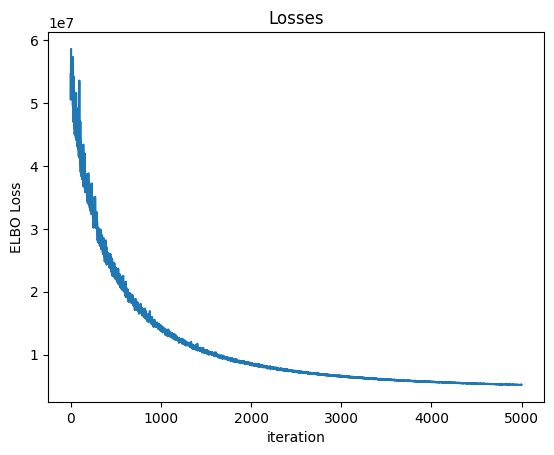

In [11]:
# plot the losses
plotter.plot_loss()
plt.show()

Next we plot the distribution of the $phi_g$ values. These are the gene-specific dispersion values.

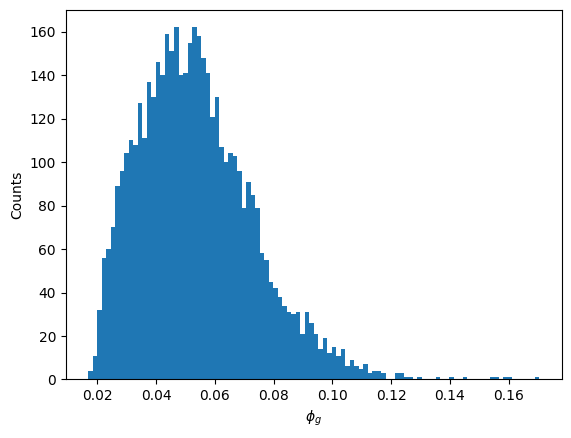

In [12]:
# examine the per-gene dispersions
plotter.plot_phi_g_distribution()
plt.show()

Next we plot the distibution of the $\beta_g$ values. These are gene-specific capture rates for the single-cell data reference generration.

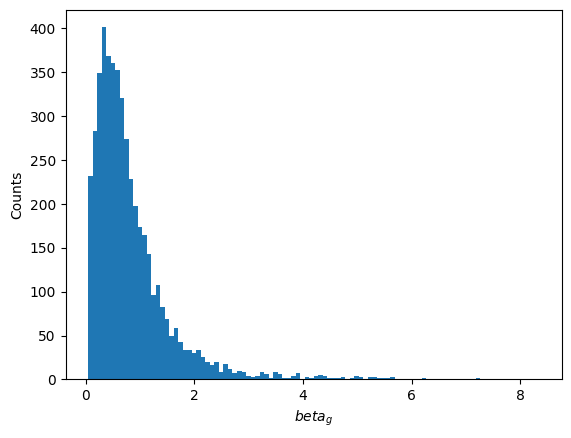

In [13]:
# examine the gene-specific capture rates
plotter.plot_beta_g_distribution()
plt.show()

We can now generate a plot of sample-specific compositons in scatter format.

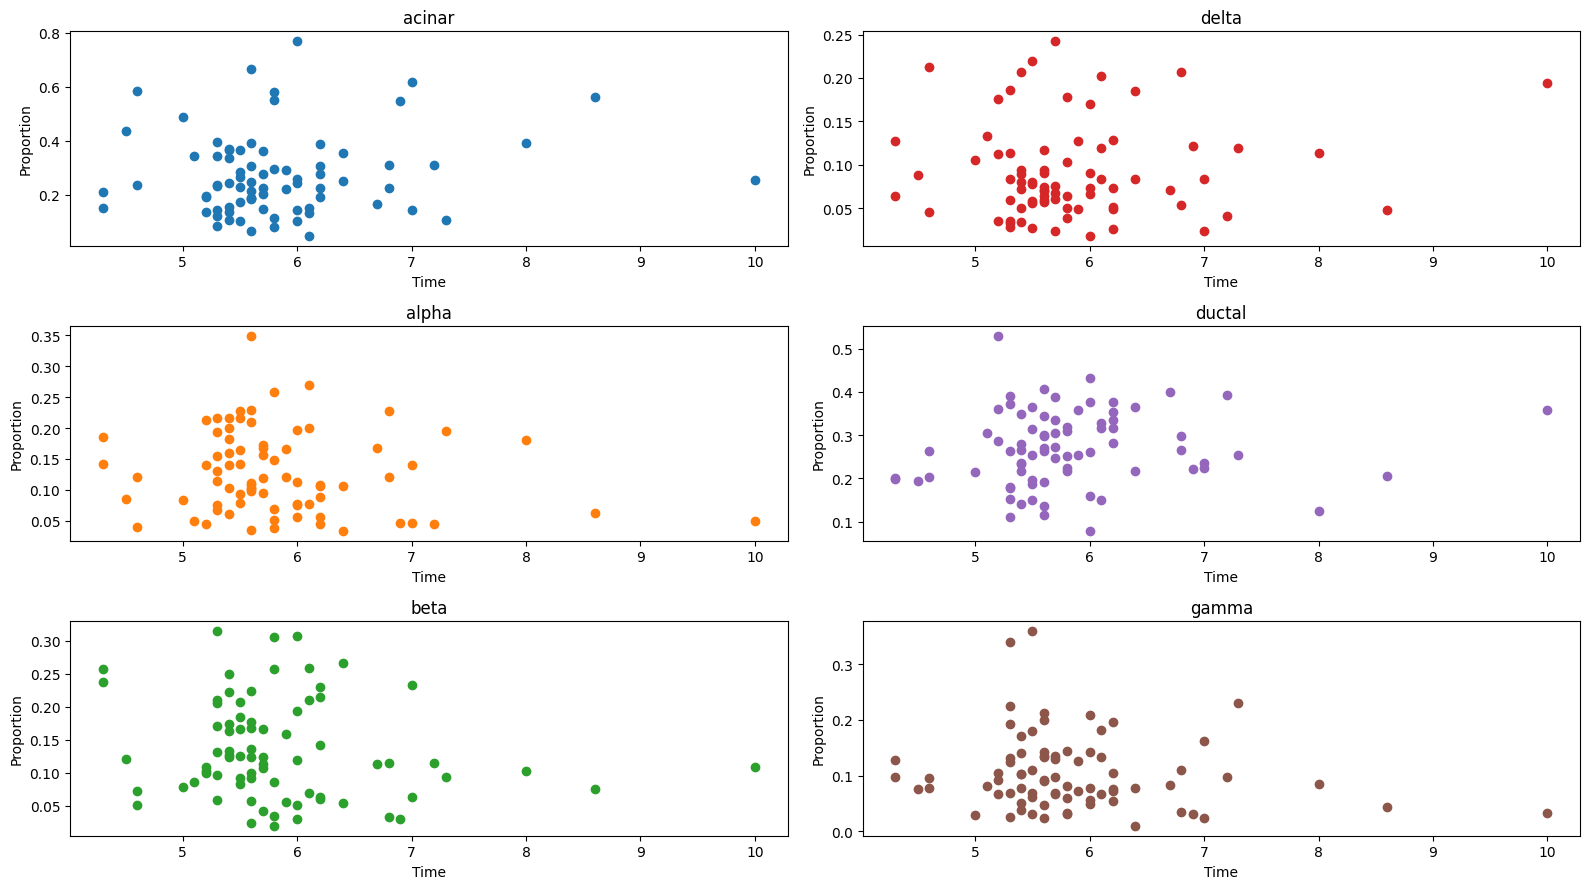

In [14]:
# Plot samples specific compositions in scatter format
plotter.plot_sample_compositions_scatter()

A better way to examine the output trajectories is to directly draw trajectory samples from the posterior. This allows us to ascertain the confidence in the trajectory estimation. The following function draws samples form the posterior and calculates IQR ranges of the trajectories.

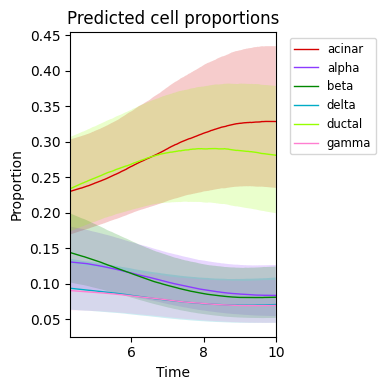

In [15]:
plotter.plot_composition_trajectories_via_posterior_sampling(figsize=(4.0,4.0),show_combined=True, filenames=('./TeRNAdecov__trajectories_with_error.pdf',))

An alternative way plotting composition trajectories is by directly plotting the mean trajectory from the GP (as opposed the the mean of samples). This is less noisy that the plot above, buyt does not provide and information on the error estimates of each plot.

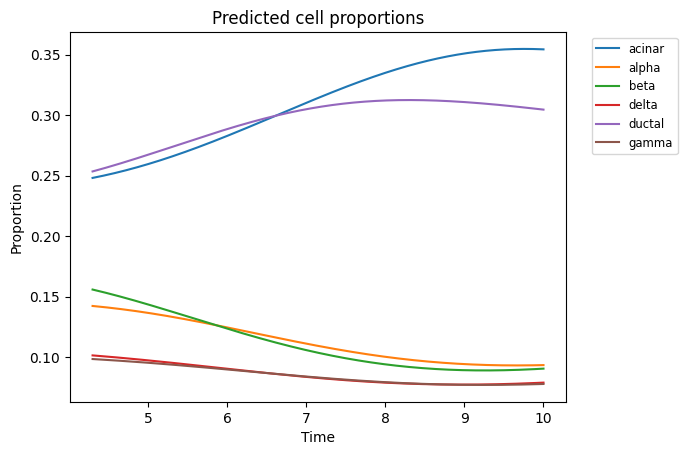

In [16]:
ax = plotter.plot_composition_trajectories(filenames=('./TeRNAdecov__trajectories.pdf',))

### Extracting values
Finally, we may wish to extract specific estimates from the deconvolution. We can do this with the help of the `DeconvolutionWriter`, which can both return data in tabular (usually pandas) format, or write them to disk using the `filename` argument.

In [17]:
writer = DeconvolutionWriter(deconv)

In [18]:
writer.write_cell_compositions(return_table=True)

,Time,Component,percent
0,4.300000,acinar,0.248118
1,4.305706,acinar,0.248192
2,4.311411,acinar,0.248266
3,4.317117,acinar,0.248340
4,4.322823,acinar,0.248415
...,...,...,...
5995,9.977177,gamma,0.077906
5996,9.982883,gamma,0.077918
5997,9.988588,gamma,0.077929
5998,9.994294,gamma,0.077940


In [19]:
sample_deconv_output_df = writer.write_sample_draws_quantiles(return_table=True)
sample_deconv_output_df

,quantile,sample,celltype,values
0,0,1,acinar,0.115641
1,0,1,alpha,0.022453
2,0,1,beta,0.015229
3,0,1,delta,0.010936
4,0,1,ductal,0.184378
...,...,...,...,...
2305,4,89,alpha,0.404739
2306,4,89,beta,0.403641
2307,4,89,delta,0.310911
2308,4,89,ductal,0.316838


## Compare with MuSiC results

In [20]:
comp_key = 'MuSiC_matched'
other_deconv_data_dict = dict()
for cell_type in included_cell_types:
    sub_table = meta_df[meta_df['cell_type'] == cell_type]
    subject_ids = list(x.replace('Sub', '') for x in sub_table['Subject'].values)
    cell_pop = sub_table[comp_key].values
    a1c = sub_table['A1C'].values
    other_deconv_data_dict[cell_type] = dict(
        subject_ids=subject_ids,
        cell_pop=cell_pop,
        a1c=a1c)
    
self_deconv_data_dict = dict()
subject_id_to_a1c_map 
for cell_type in included_cell_types:
    sub_table = sample_deconv_output_df[sample_deconv_output_df['quantile'] == '2']
    sub_table = sub_table[sub_table['celltype'] == cell_type]
    subject_ids = list(sub_table['sample'])
    cell_pop = list(sub_table['values'])
    a1c = list(map(subject_id_to_a1c_map.get, subject_ids))
    self_deconv_data_dict[cell_type] = dict(
        subject_ids=subject_ids,
        cell_pop=cell_pop,
        a1c=a1c)

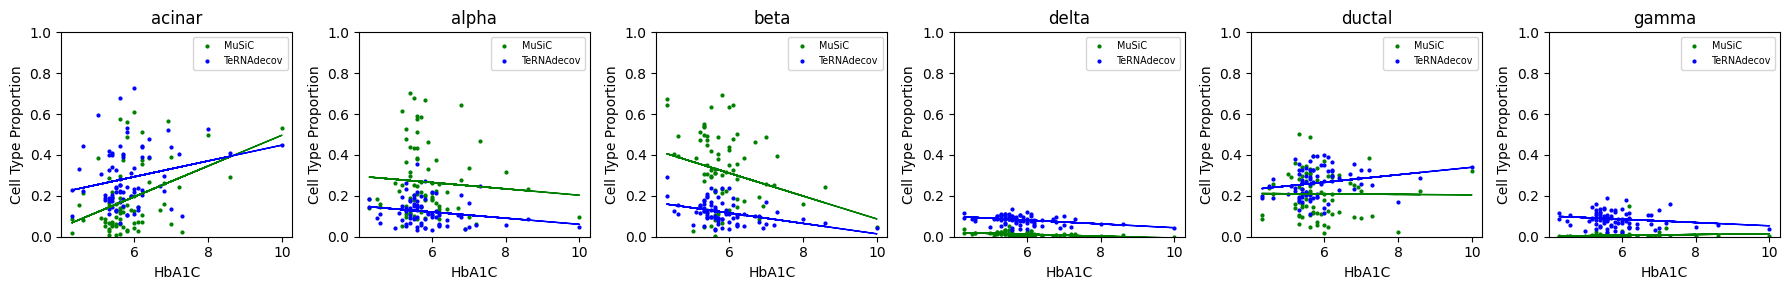

In [27]:
from sklearn.linear_model import LinearRegression

n_cell_types = len(included_cell_types)
scale = 3.
fig, axs = plt.subplots(ncols=n_cell_types, figsize=(1 * scale * n_cell_types, scale))
for i_cell_type in range(n_cell_types):
    cell_type = included_cell_types[i_cell_type]
    ax = axs[i_cell_type]
    
    x = np.asarray(other_deconv_data_dict[cell_type]['a1c'])
    y = np.asarray(other_deconv_data_dict[cell_type]['cell_pop'])
    fit = LinearRegression().fit(x[:, None], y)
    y_pred = fit.predict(x[:, None])
    ax.scatter(x, y, s=4, color='green', label='MuSiC')
    ax.plot(x, y_pred, color='green', lw=1)
    
    x = np.asarray(self_deconv_data_dict[cell_type]['a1c'])
    y = np.asarray(self_deconv_data_dict[cell_type]['cell_pop'])
    fit = LinearRegression().fit(x[:, None], y)
    y_pred = fit.predict(x[:, None])
    ax.scatter(x, y, s=4, color='blue', label='TeRNAdecov')
    ax.plot(x, y_pred, color='blue', lw=1)
    
    # set the same y-scale for all plots
    ax.set_ylim([0, 1.])
    
    ax.set_title(cell_type)
    ax.set_xlabel('HbA1C')
    ax.set_ylabel('Cell Type Proportion')
    ax.legend(fontsize='x-small')

fig.tight_layout()
fig.savefig('./MuSiC_vs_TeRNAdecov__cell_proportion_vs_HbA1C.pdf')

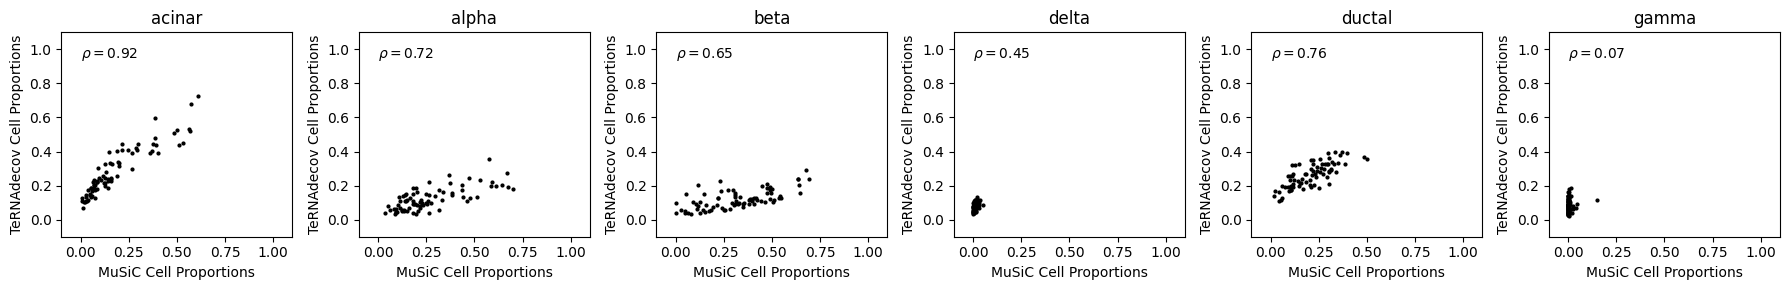

In [22]:
from scipy.stats import pearsonr

n_cell_types = len(included_cell_types)
scale = 3
fig, axs = plt.subplots(ncols=n_cell_types, figsize=(1. * scale * n_cell_types, scale))
for i_cell_type in range(n_cell_types):
    cell_type = included_cell_types[i_cell_type]
    ax = axs[i_cell_type]

    x = other_deconv_data_dict[cell_type]['cell_pop']
    y = self_deconv_data_dict[cell_type]['cell_pop']
    rho = pearsonr(x, y).statistic
    ax.text(0, 0.95, f'$\\rho = {rho:.2f}$')
    ax.scatter(x, y, s=4, color='black')
    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([-0.1, 1.1])
    ax.set_title(cell_type)
    ax.set_xlabel('MuSiC Cell Proportions')
    ax.set_ylabel('TeRNAdecov Cell Proportions')
    
fig.tight_layout()
fig.savefig('./MuSiC_vs_TeRNAdecov__by_cell_type.pdf')